# Class Conditioning and Classifier-Free Guidance

In the previous notebooks, we built generative models that produce **random** digits. We had no control over *which* digit comes out - the model just samples from the entire data distribution.

In this notebook, we add **class conditioning** - the ability to say "generate a 7" and actually get a 7. This seemingly simple addition requires one of the most important techniques in modern generative AI: **Classifier-Free Guidance (CFG)**.

## From Unconditional to Conditional Generation

| Previous Notebooks | This Notebook |
|-------------------|---------------|
| $p(x)$ | $p(x \mid y)$ |
| Generate any digit | Generate digit of class $y$ |
| Random output | Controlled output |

Instead of learning the marginal distribution $p(x)$, we learn the **conditional distribution** $p(x \mid y)$ where $y \in \{0, 1, \ldots, 9\}$ specifies which digit we want.

## Why Class Conditioning Matters

Class conditioning is a **stepping stone** to text conditioning. The principles are identical:

| Application | Condition $y$ | What We're Learning |
|-------------|---------------|--------------------|
| This notebook | Digit class (0-9) | $p(x \mid y = \text{digit})$ |
| Stable Diffusion | Text prompt | $p(x \mid y = \text{"a cat sitting on a mat"})$ |
| DALL-E | Text description | $p(x \mid y = \text{any text})$ |

Master this notebook, and you'll understand how text-to-image models work.

## The Mathematical Framework

We modify our flow matching objective to be conditioned on class $y$:

**Unconditional (before):**
$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t} \left[ \| v_\theta(x_t, t) - (x_1 - x_0) \|^2 \right]$$

**Conditional (now):**
$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t, y} \left[ \| v_\theta(x_t, t, y) - (x_1 - x_0) \|^2 \right]$$

The velocity field $v_\theta$ now takes the class label $y$ as an additional input.

## What We'll Learn

1. **Class Embeddings** - Converting discrete labels to learnable vectors
2. **Conditioning Mechanism** - How to inject class information into the model
3. **Classifier-Free Guidance** - The technique that makes conditioning actually work
4. **Label Dropout** - Training trick that enables CFG

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

from from_noise_to_images import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## Step 1: Class Embeddings - Discrete Labels to Continuous Vectors

Our class labels are integers: $y \in \{0, 1, 2, \ldots, 9\}$. But neural networks work with continuous vectors. How do we bridge this gap?

### The Embedding Function

We define an **embedding function** $e: \mathcal{Y} \to \mathbb{R}^D$ that maps each class to a learnable vector:

$$e(y) = W_e[y] \in \mathbb{R}^D$$

where:
- $\mathcal{Y} = \{0, 1, \ldots, K-1\}$ is the set of $K$ classes
- $W_e \in \mathbb{R}^{K \times D}$ is a learnable **embedding matrix**
- $W_e[y]$ denotes the $y$-th row of $W_e$

For MNIST with $K=10$ classes and embedding dimension $D=1024$:

$$W_e = \begin{bmatrix} 
- & e_0 & - \\
- & e_1 & - \\
& \vdots & \\
- & e_9 & -
\end{bmatrix} \in \mathbb{R}^{10 \times 1024}$$

Each row $e_i$ is the learnable embedding for digit $i$.

### Why Embeddings Work

| Property | Why It Helps |
|----------|-------------|
| **Gradient flow** | Each $e_i$ gets gradients only when class $i$ is used |
| **Representation learning** | Network learns to place similar classes nearby |
| **Flexibility** | Unlike one-hot, can capture class relationships |

### The Null Class: A Critical Addition

For Classifier-Free Guidance (explained in Step 3), we need a special **null class** $\emptyset$ representing "no conditioning":

$$\mathcal{Y}_{\text{extended}} = \{0, 1, \ldots, K-1, \emptyset\}$$

This gives us $K+1 = 11$ embeddings. We use index 10 for the null class:

$$e_\emptyset = W_e[10]$$

The null embedding is learned during training and represents "generate any digit."

Embedding table shape: torch.Size([11, 1024])
  - 11 classes (10 digits + 1 null class)
  - 1024 dimensions per class


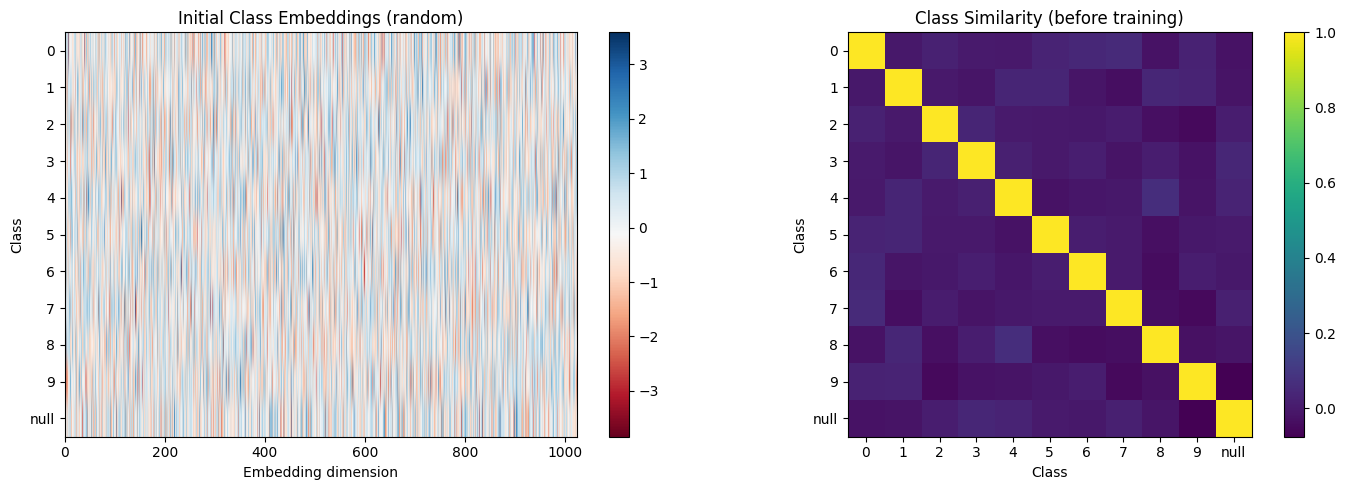


Before training, all classes have random, uncorrelated embeddings.
After training, similar digits (like 3 and 8) may become more similar!


In [2]:
from from_noise_to_images.dit import ClassEmbedding

# Create a class embedding layer
num_classes = 10
embed_dim = 1024  # Same as cond_dim in our model
class_embed = ClassEmbedding(num_classes, embed_dim)

print(f"Embedding table shape: {class_embed.embed.weight.shape}")
print(f"  - {num_classes + 1} classes (10 digits + 1 null class)")
print(f"  - {embed_dim} dimensions per class")

# Visualize the initial embeddings
with torch.no_grad():
    all_embeddings = class_embed.embed.weight.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Show the embedding matrix
im = axes[0].imshow(all_embeddings, aspect='auto', cmap='RdBu')
axes[0].set_xlabel('Embedding dimension')
axes[0].set_ylabel('Class')
axes[0].set_yticks(range(11))
axes[0].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[0].set_title('Initial Class Embeddings (random)')
plt.colorbar(im, ax=axes[0])

# Show similarity matrix
similarity = np.corrcoef(all_embeddings)
im = axes[1].imshow(similarity, cmap='viridis')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Class')
axes[1].set_xticks(range(11))
axes[1].set_xticklabels([str(i) for i in range(10)] + ['null'])
axes[1].set_yticks(range(11))
axes[1].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[1].set_title('Class Similarity (before training)')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

print("\nBefore training, all classes have random, uncorrelated embeddings.")
print("After training, similar digits (like 3 and 8) may become more similar!")

## Step 2: Combining Time and Class Conditioning

In the previous notebook, our DiT was conditioned only on timestep $t$. Now we add class conditioning. The question: how do we combine these two pieces of information?

### The Two Conditioning Signals

- **Timestep**: $t \in [0, 1]$ → embedded as $h_t = \text{TimeEmbed}(t) \in \mathbb{R}^D$
- **Class**: $y \in \{0, \ldots, 9\}$ → embedded as $h_y = e(y) \in \mathbb{R}^D$

We need to combine these into a single conditioning vector $c \in \mathbb{R}^D$.

### Addition: The Simplest Approach

We use **element-wise addition**:

$$c = h_t + h_y = \text{TimeEmbed}(t) + e(y)$$

This works because:

| Property | Why It Works |
|----------|-------------|
| **Superposition** | Network can learn to disentangle the two signals |
| **Shared space** | Both embeddings live in the same $\mathbb{R}^D$ |
| **Efficiency** | No additional parameters or operations |

### How the Model Uses Combined Conditioning

The combined conditioning $c$ feeds into adaLN (from the previous notebook):

$$\text{adaLN}(x, c) = \gamma(c) \odot \frac{x - \mu}{\sigma} + \beta(c)$$

Expanding with our combined conditioning:

$$\gamma(c) = \gamma(h_t + h_y) = W_\gamma h_t + W_\gamma h_y + b_\gamma$$

The network learns to use both time and class information through these modulation parameters.

### Architecture Comparison

```
Before (Unconditional)           After (Class-Conditional)
                                 
   Timestep t                       Timestep t    Class y
      │                                │            │
      ▼                                ▼            ▼
  TimeEmbed                        TimeEmbed    ClassEmbed
      │                                │            │
      ▼                                └─────┬──────┘
   h_t ∈ ℝᴰ                                 +
      │                                      │
      ▼                                      ▼
   adaLN                                c ∈ ℝᴰ
      │                                      │
      ▼                                      ▼
   DiT Blocks                             adaLN
                                             │
                                             ▼
                                         DiT Blocks
```

Conditioning Vector Construction:
  Time embedding:   torch.Size([1, 1024]) → represents t=0.3
  Class embedding:  torch.Size([1, 1024]) → represents digit 7
  Combined:         torch.Size([1, 1024]) → used for adaLN conditioning


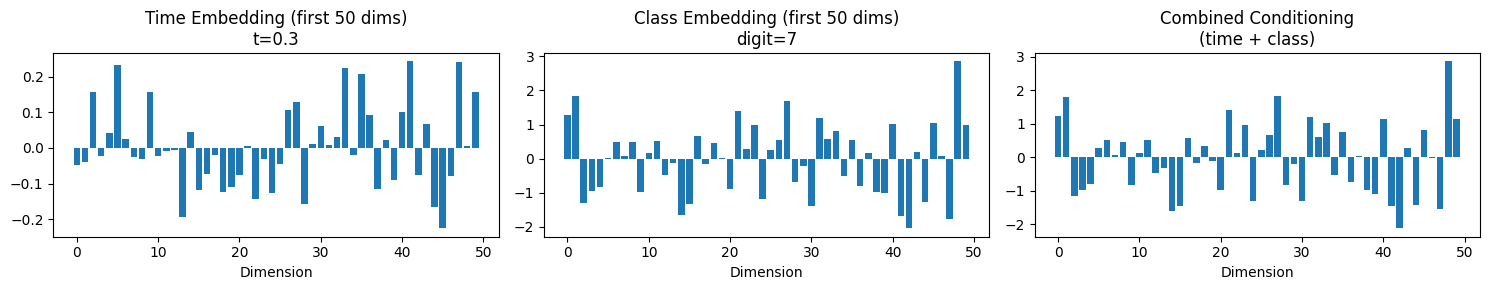

In [3]:
from from_noise_to_images.dit import TimestepEmbedding, ClassEmbedding

# Create embedding modules
embed_dim = 256
cond_dim = embed_dim * 4  # 1024

time_embed = TimestepEmbedding(embed_dim, cond_dim)
class_embed = ClassEmbedding(10, cond_dim)

# Sample inputs
t = torch.tensor([0.3])  # Timestep
y = torch.tensor([7])    # Class label (digit 7)

with torch.no_grad():
    time_cond = time_embed(t)
    class_cond = class_embed(y)
    combined = time_cond + class_cond

print("Conditioning Vector Construction:")
print(f"  Time embedding:   {time_cond.shape} → represents t={t.item():.1f}")
print(f"  Class embedding:  {class_cond.shape} → represents digit {y.item()}")
print(f"  Combined:         {combined.shape} → used for adaLN conditioning")

# Visualize the combination
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

axes[0].bar(range(50), time_cond[0, :50].numpy())
axes[0].set_title(f'Time Embedding (first 50 dims)\nt={t.item():.1f}')
axes[0].set_xlabel('Dimension')

axes[1].bar(range(50), class_cond[0, :50].numpy())
axes[1].set_title(f'Class Embedding (first 50 dims)\ndigit={y.item()}')
axes[1].set_xlabel('Dimension')

axes[2].bar(range(50), combined[0, :50].numpy())
axes[2].set_title('Combined Conditioning\n(time + class)')
axes[2].set_xlabel('Dimension')

plt.tight_layout()
plt.show()

## Step 3: Classifier-Free Guidance (CFG)

Here's a problem: simply training with class labels and sampling with class labels often produces "weak" conditioning. The model generates vaguely correct digits, but they don't really "pop."

**Classifier-Free Guidance (CFG)** solves this. It's arguably the most important technique in modern conditional generation.

### The Score Function Perspective

Using Bayes' rule for conditional distributions:

$$\log p(x \mid y) = \log p(y \mid x) + \log p(x) - \log p(y)$$

Taking gradients with respect to $x$:

$$\nabla_x \log p(x \mid y) = \nabla_x \log p(y \mid x) + \nabla_x \log p(x)$$

Rearranging:

$$\underbrace{\nabla_x \log p(x \mid y)}_{\text{conditional score}} = \underbrace{\nabla_x \log p(x)}_{\text{unconditional}} + \underbrace{\nabla_x \log p(y \mid x)}_{\text{"classifier" gradient}}$$

### The CFG Insight: Amplify the Class Signal

CFG amplifies the "classifier gradient" term by a factor $w > 1$:

$$\nabla_x \log p_{\text{CFG}}(x \mid y) = \nabla_x \log p(x) + w \cdot \nabla_x \log p(y \mid x)$$

Since $\nabla_x \log p(y \mid x) = \nabla_x \log p(x \mid y) - \nabla_x \log p(x)$, we get:

$$\nabla_x \log p_{\text{CFG}} = (1 - w) \cdot \nabla_x \log p(x) + w \cdot \nabla_x \log p(x \mid y)$$

### The CFG Formula for Velocity Fields

In flow matching, the velocity field $v_\theta$ is closely related to the score function. For the linear interpolation path we use, the velocity and score point in the same direction. both guide the sample toward the data distribution. This means the same amplification trick works: we can replace score functions with velocities and get the same effect.

$$\boxed{v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})}$$

Or equivalently:

$$v_{\text{CFG}} = (1 - w) \cdot v_{\text{uncond}} + w \cdot v_{\text{cond}}$$

where:
- $v_{\text{cond}} = v_\theta(x_t, t, y)$: Velocity with class label
- $v_{\text{uncond}} = v_\theta(x_t, t, \emptyset)$: Velocity with null class
- $w$: Guidance scale (typically 3-7)

### Intuitive Understanding

| Term | What It Represents |
|------|-------------------|
| $v_{\text{uncond}}$ | "What does any digit look like at this noise level?" |
| $v_{\text{cond}}$ | "What does digit $y$ look like at this noise level?" |
| $v_{\text{cond}} - v_{\text{uncond}}$ | "What makes this specifically digit $y$?" |
| $w \cdot (\ldots)$ | "Amplify the $y$-specific features" |

### Effect of Guidance Scale

| Scale $w$ | Mathematical Effect | Practical Result |
|-----------|---------------------|------------------|
| $w = 0$ | $v_{\text{CFG}} = v_{\text{uncond}}$ | Pure unconditional |
| $w = 1$ | $v_{\text{CFG}} = v_{\text{cond}}$ | No guidance amplification |
| $w = 3\text{-}5$ | Balanced amplification | Good balance |
| $w > 7$ | Strong amplification | May over-saturate |

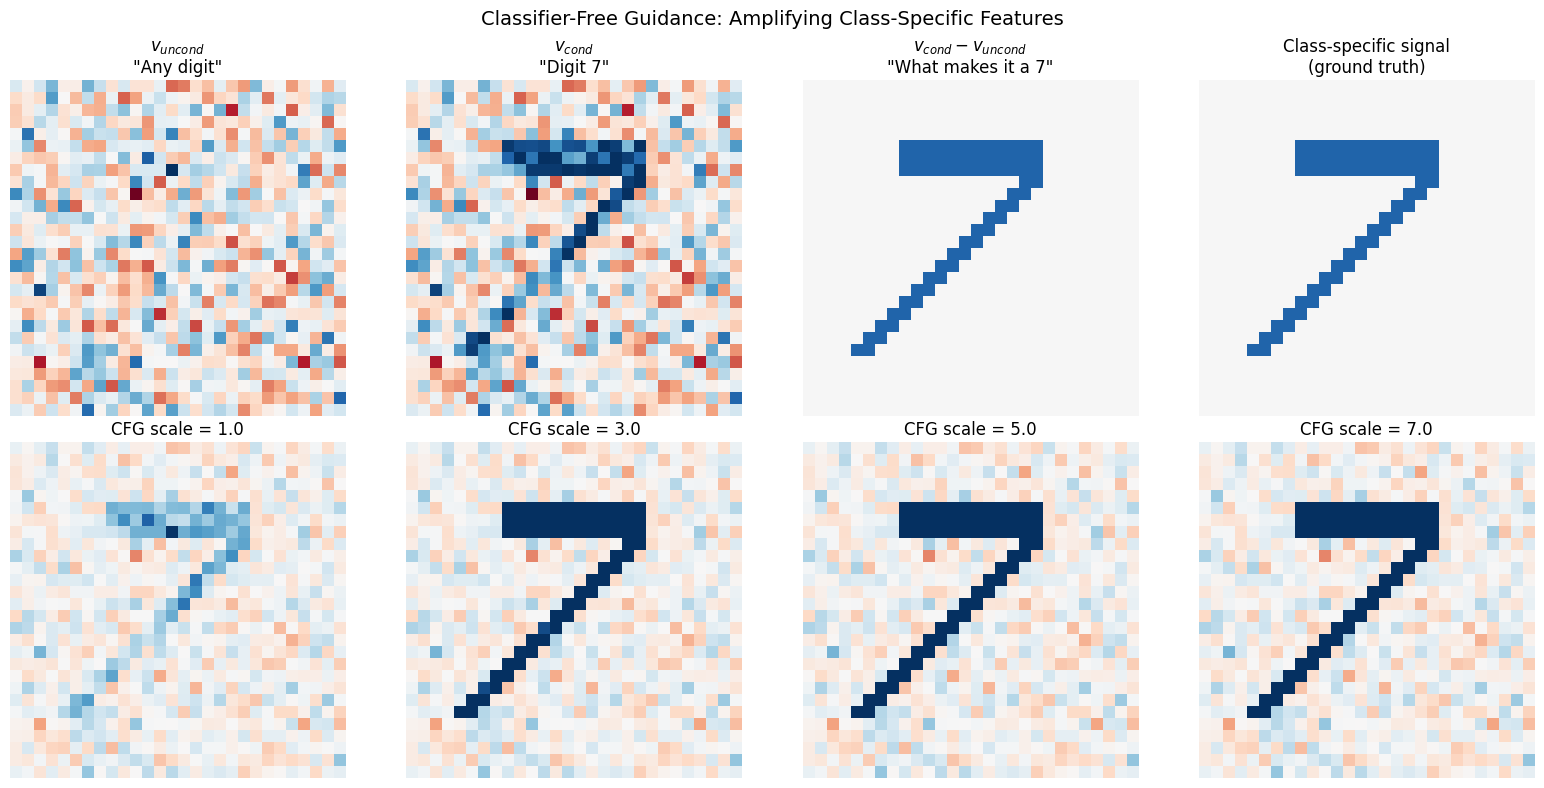


CFG Formula: v_guided = v_uncond + scale × (v_cond - v_uncond)

  • scale=1: Pure conditional (no amplification)
  • scale>1: Amplifies what the class 'adds' to the prediction
  • Higher scale = stronger class adherence, may reduce diversity


In [4]:
def visualize_cfg_concept():
    """
    Visualize how CFG amplifies the conditional signal.
    """
    np.random.seed(42)
    
    # Unconditional: generic velocity field
    v_uncond = np.random.randn(28, 28) * 0.3
    
    # Conditional: adds class-specific structure (e.g., "7" shape)
    v_class_specific = np.zeros((28, 28))
    # Horizontal bar at top (the top of a 7)
    v_class_specific[5:8, 8:20] = 0.8
    # Diagonal stroke
    for i in range(15):
        v_class_specific[8+i, 18-i:20-i] = 0.8
    
    v_cond = v_uncond + v_class_specific
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: The components
    im = axes[0, 0].imshow(v_uncond, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 0].set_title('$v_{uncond}$\n"Any digit"', fontsize=12)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(v_cond, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 1].set_title('$v_{cond}$\n"Digit 7"', fontsize=12)
    axes[0, 1].axis('off')
    
    difference = v_cond - v_uncond
    axes[0, 2].imshow(difference, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 2].set_title('$v_{cond} - v_{uncond}$\n"What makes it a 7"', fontsize=12)
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(v_class_specific, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 3].set_title('Class-specific signal\n(ground truth)', fontsize=12)
    axes[0, 3].axis('off')
    
    # Row 2: Different CFG scales
    scales = [1.0, 3.0, 5.0, 7.0]
    
    for i, scale in enumerate(scales):
        v_guided = v_uncond + scale * difference
        axes[1, i].imshow(v_guided, cmap='RdBu', vmin=-2, vmax=2)
        axes[1, i].set_title(f'CFG scale = {scale}', fontsize=12)
        axes[1, i].axis('off')
    
    plt.suptitle('Classifier-Free Guidance: Amplifying Class-Specific Features', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nCFG Formula: v_guided = v_uncond + scale × (v_cond - v_uncond)")
    print("\n  • scale=1: Pure conditional (no amplification)")
    print("  • scale>1: Amplifies what the class 'adds' to the prediction")
    print("  • Higher scale = stronger class adherence, may reduce diversity")

visualize_cfg_concept()

## Step 4: Label Dropout - Training for CFG

For CFG to work at inference, we run the model **twice**: once conditional ($v_{\text{cond}}$) and once unconditional ($v_{\text{uncond}}$). But how does a single model learn both behaviors?

### The Solution: Probabilistic Label Dropout

During training, we **randomly drop the class label** with probability $p_{\text{drop}}$:

$$y_{\text{train}} = \begin{cases}
y & \text{with probability } 1 - p_{\text{drop}} \\
\emptyset & \text{with probability } p_{\text{drop}}
\end{cases}$$

Typically $p_{\text{drop}} = 0.1$ (10%).

### What the Model Learns

| Training Mode | Fraction | What the Model Learns |
|---------------|----------|-----------------------|
| Conditional | 90% | $v_\theta(x_t, t, y) \approx \mathbb{E}[v \mid x_t, t, y]$ |
| Unconditional | 10% | $v_\theta(x_t, t, \emptyset) \approx \mathbb{E}[v \mid x_t, t]$ |

The **same model** learns both the conditional and marginal velocity fields!

### The Null Embedding

When the label is dropped, we use a learned **null embedding** $e_\emptyset$:

$$c_{\text{uncond}} = h_t + e_\emptyset$$

rather than just zeroing out the class signal. This lets the model learn a proper representation for "no class specified."

### Why 10% Dropout?

| Dropout Rate | Issue |
|--------------|-------|
| Too low (1%) | Model rarely sees unconditional → poor $v_{\text{uncond}}$ |
| Too high (50%) | Model sees fewer conditional → weaker $v_{\text{cond}}$ |
| 10% | Empirically good balance |

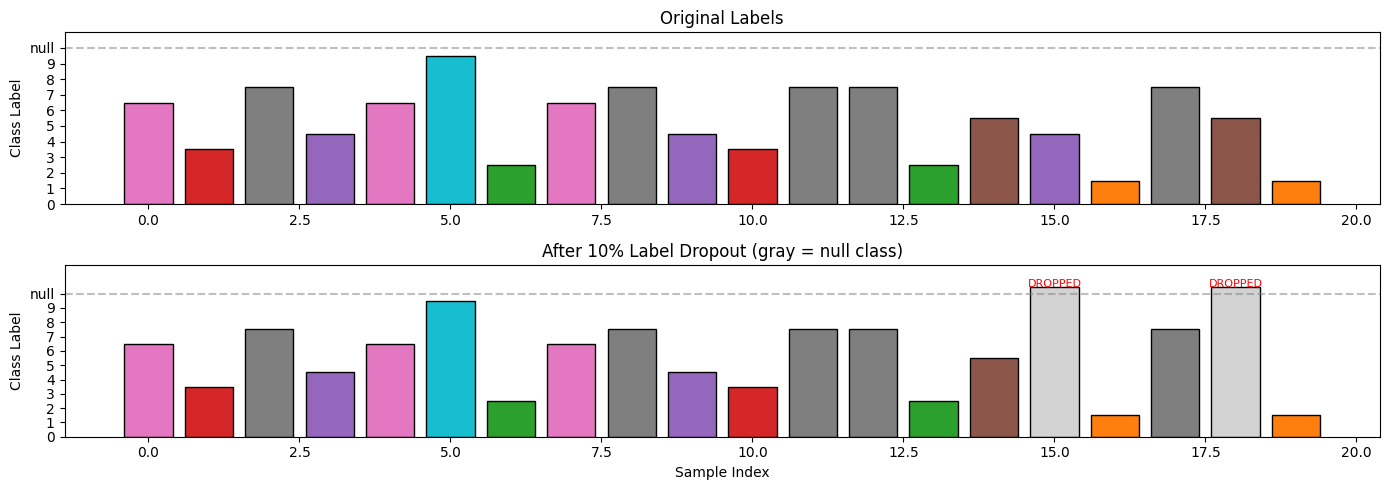


Label Dropout Statistics:
  • Total samples: 20
  • Dropped: 2 (10%)
  • Kept: 18 (90%)


In [5]:
def visualize_label_dropout():
    """
    Show how label dropout works during training.
    """
    np.random.seed(42)
    batch_size = 20
    drop_prob = 0.1
    
    # Simulate original labels
    original_labels = np.random.randint(0, 10, batch_size)
    
    # Simulate dropout
    drop_mask = np.random.rand(batch_size) < drop_prob
    labels_after_dropout = original_labels.copy()
    labels_after_dropout[drop_mask] = 10  # Null class
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 5))
    
    # Original labels
    colors = plt.cm.tab10(original_labels / 10)
    bars = axes[0].bar(range(batch_size), original_labels + 0.5, color=colors, edgecolor='black')
    axes[0].set_ylabel('Class Label')
    axes[0].set_title('Original Labels', fontsize=12)
    axes[0].set_ylim(0, 11)
    axes[0].set_yticks(range(11))
    axes[0].set_yticklabels([str(i) for i in range(10)] + ['null'])
    axes[0].axhline(y=10, color='gray', linestyle='--', alpha=0.5)
    
    # After dropout
    colors_after = []
    for i, (orig, after) in enumerate(zip(original_labels, labels_after_dropout)):
        if after == 10:  # Dropped
            colors_after.append('lightgray')
        else:
            colors_after.append(plt.cm.tab10(orig / 10))
    
    bars = axes[1].bar(range(batch_size), labels_after_dropout + 0.5, color=colors_after, edgecolor='black')
    # Highlight dropped samples
    for i, dropped in enumerate(drop_mask):
        if dropped:
            axes[1].annotate('DROPPED', (i, 10.5), ha='center', fontsize=8, color='red')
    
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Class Label')
    axes[1].set_title(f'After {drop_prob*100:.0f}% Label Dropout (gray = null class)', fontsize=12)
    axes[1].set_ylim(0, 12)
    axes[1].set_yticks(range(11))
    axes[1].set_yticklabels([str(i) for i in range(10)] + ['null'])
    axes[1].axhline(y=10, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nLabel Dropout Statistics:")
    print(f"  • Total samples: {batch_size}")
    print(f"  • Dropped: {drop_mask.sum()} ({drop_mask.mean()*100:.0f}%)")
    print(f"  • Kept: {(~drop_mask).sum()} ({(~drop_mask).mean()*100:.0f}%)")

visualize_label_dropout()

## Step 5: The Conditional DiT Architecture

The changes from the unconditional DiT are minimal but powerful.

### Forward Pass Comparison

**Before (Unconditional):**
$$v_\theta(x, t) = \text{DiT}(x, \text{TimeEmbed}(t))$$

**After (Conditional):**
$$v_\theta(x, t, y) = \text{ConditionalDiT}(x, \text{TimeEmbed}(t) + e(y))$$

### Architecture Summary

| Component | Equation | Shape |
|-----------|----------|-------|
| Time embedding | $h_t = \text{TimeEmbed}(t)$ | $\mathbb{R}^D$ |
| Class embedding | $h_y = e(y) = W_e[y]$ | $\mathbb{R}^D$ |
| Combined | $c = h_t + h_y$ | $\mathbb{R}^D$ |
| adaLN | $\gamma, \beta = \text{Linear}(c)$ | $\mathbb{R}^{d_{\text{model}}}$ each |

### Additional Parameters

The only new parameters are the class embeddings:

$$\Delta_{\text{params}} = (K + 1) \times D = 11 \times 1024 = 11,264$$

That's it - about 0.1% of the model!

In [6]:
from from_noise_to_images.dit import ConditionalDiT

# Create the conditional DiT model
model = ConditionalDiT(
    num_classes=10,     # 10 digit classes
    img_size=28,        # MNIST image size
    patch_size=4,       # 4×4 patches → 7×7 = 49 patches
    in_channels=1,      # Grayscale
    embed_dim=256,      # Embedding dimension
    depth=6,            # Number of transformer blocks
    num_heads=8,        # Attention heads
    mlp_ratio=4.0,      # MLP expansion
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"ConditionalDiT Parameters: {num_params:,}")

# Compare to unconditional DiT
from from_noise_to_images.dit import DiT
uncond_model = DiT()
uncond_params = sum(p.numel() for p in uncond_model.parameters() if p.requires_grad)
print(f"Unconditional DiT Parameters: {uncond_params:,}")
print(f"Difference: {num_params - uncond_params:,} (the class embeddings)")

# Test forward pass with different inputs
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)
test_y = torch.randint(0, 10, (4,), device=device)

print("\n--- Testing Forward Pass ---")

# With class labels
with torch.no_grad():
    out_cond = model(test_x, test_t, test_y)
print(f"With class labels:    input {test_x.shape} → output {out_cond.shape}")

# Without class labels (unconditional)
with torch.no_grad():
    out_uncond = model(test_x, test_t, y=None)
print(f"Without class labels: input {test_x.shape} → output {out_uncond.shape}")

print("\nModel handles both conditional and unconditional forward passes!")

ConditionalDiT Parameters: 12,363,024
Unconditional DiT Parameters: 12,351,760
Difference: 11,264 (the class embeddings)

--- Testing Forward Pass ---


With class labels:    input torch.Size([4, 1, 28, 28]) → output torch.Size([4, 1, 28, 28])
Without class labels: input torch.Size([4, 1, 28, 28]) → output torch.Size([4, 1, 28, 28])

Model handles both conditional and unconditional forward passes!


## Step 6: Training with Label Dropout

The training loop is nearly identical to before, with one key addition: label dropout.

### Training Algorithm

For each training sample $(x_0, y)$ where $x_0$ is an image and $y$ is its class:

1. **Sample noise and time**: $x_1 \sim \mathcal{N}(0, I)$, $t \sim \text{Uniform}(0, 1)$
2. **Interpolate**: $x_t = (1-t) x_0 + t x_1$
3. **Apply label dropout**:
$$y_{\text{train}} = \begin{cases} y & \text{w.p. } 0.9 \\ \emptyset & \text{w.p. } 0.1 \end{cases}$$
4. **Compute loss**: $\mathcal{L} = \| v_\theta(x_t, t, y_{\text{train}}) - (x_1 - x_0) \|^2$
5. **Backpropagate and update**

### Pseudocode

```python
for x_0, y in dataloader:
    x_1 = torch.randn_like(x_0)           # Sample noise
    t = torch.rand(batch_size)             # Sample timesteps
    x_t = (1-t)*x_0 + t*x_1                # Interpolate
    
    # Label dropout: replace 10% of labels with null class
    drop_mask = torch.rand(batch_size) < 0.1
    y_train = y.clone()
    y_train[drop_mask] = NULL_CLASS
    
    v_pred = model(x_t, t, y_train)        # Predict velocity
    v_true = x_1 - x_0                     # True velocity
    loss = mse_loss(v_pred, v_true)        # MSE loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

In [7]:
# Load MNIST with labels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

# Show sample data
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels: {labels[:10].tolist()}...")

Batch shape: torch.Size([128, 1, 28, 28])
Labels: [9, 3, 1, 1, 3, 3, 7, 9, 7, 3]...


In [8]:
from from_noise_to_images.train import ConditionalTrainer

# Create the conditional trainer
trainer = ConditionalTrainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    label_drop_prob=0.1,  # 10% label dropout for CFG
    num_classes=10,
    device=device,
)

print("Training Conditional DiT with CFG label dropout...")
print("(10% of samples trained without class labels)\n")

NUM_EPOCHS = 30
losses = trainer.train(num_epochs=NUM_EPOCHS)

Training Conditional DiT with CFG label dropout...
(10% of samples trained without class labels)

Training on cuda
Model parameters: 12,363,024
CFG label dropout: 10%


Epoch 1/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1: avg_loss = 0.8310


Epoch 2/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2: avg_loss = 0.3356


Epoch 3/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3: avg_loss = 0.2988


Epoch 4/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4: avg_loss = 0.2848


Epoch 5/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5: avg_loss = 0.2749


Epoch 6/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6: avg_loss = 0.2670


Epoch 7/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 7: avg_loss = 0.2589


Epoch 8/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 8: avg_loss = 0.2516


Epoch 9/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 9: avg_loss = 0.2429


Epoch 10/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 10: avg_loss = 0.2347


Epoch 11/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 11: avg_loss = 0.2256


Epoch 12/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 12: avg_loss = 0.2157


Epoch 13/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 13: avg_loss = 0.2093


Epoch 14/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 14: avg_loss = 0.2035


Epoch 15/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 15: avg_loss = 0.1995


Epoch 16/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 16: avg_loss = 0.1973


Epoch 17/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 17: avg_loss = 0.1942


Epoch 18/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 18: avg_loss = 0.1926


Epoch 19/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 19: avg_loss = 0.1903


Epoch 20/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 20: avg_loss = 0.1883


Epoch 21/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 21: avg_loss = 0.1872


Epoch 22/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 22: avg_loss = 0.1856


Epoch 23/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 23: avg_loss = 0.1851


Epoch 24/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 24: avg_loss = 0.1830


Epoch 25/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 25: avg_loss = 0.1825


Epoch 26/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 26: avg_loss = 0.1823


Epoch 27/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 27: avg_loss = 0.1806


Epoch 28/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 28: avg_loss = 0.1797


Epoch 29/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 29: avg_loss = 0.1788


Epoch 30/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 30: avg_loss = 0.1780


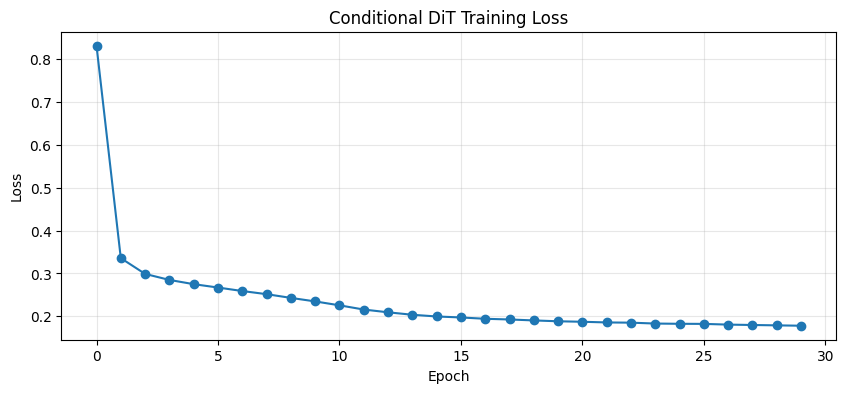


Final loss: 0.1780


In [9]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Conditional DiT Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal loss: {losses[-1]:.4f}")

## Step 7: Sampling with CFG

- generating specific digits with controllable guidance!

### CFG Sampling Algorithm

At each step of the ODE solver:

```
For each timestep t (from 1 to 0):
    v_cond = model(x_t, t, y)        # Conditional velocity
    v_uncond = model(x_t, t, null)   # Unconditional velocity
    
    # Apply CFG
    v_guided = v_uncond + w * (v_cond - v_uncond)
    
    # Euler step
    x_t = x_t - dt * v_guided
```

### Computational Cost

CFG requires **two forward passes** per sampling step:

| Method | Forward Passes per Step | Total for 50 Steps |
|--------|------------------------|-------------------|
| Unconditional | 1 | 50 |
| Conditional (no CFG) | 1 | 50 |
| Conditional + CFG | 2 | 100 |

The 2× cost is worth it for the quality improvement.

Generating 4 samples for each digit (0-9) with CFG scale=4.0...


Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

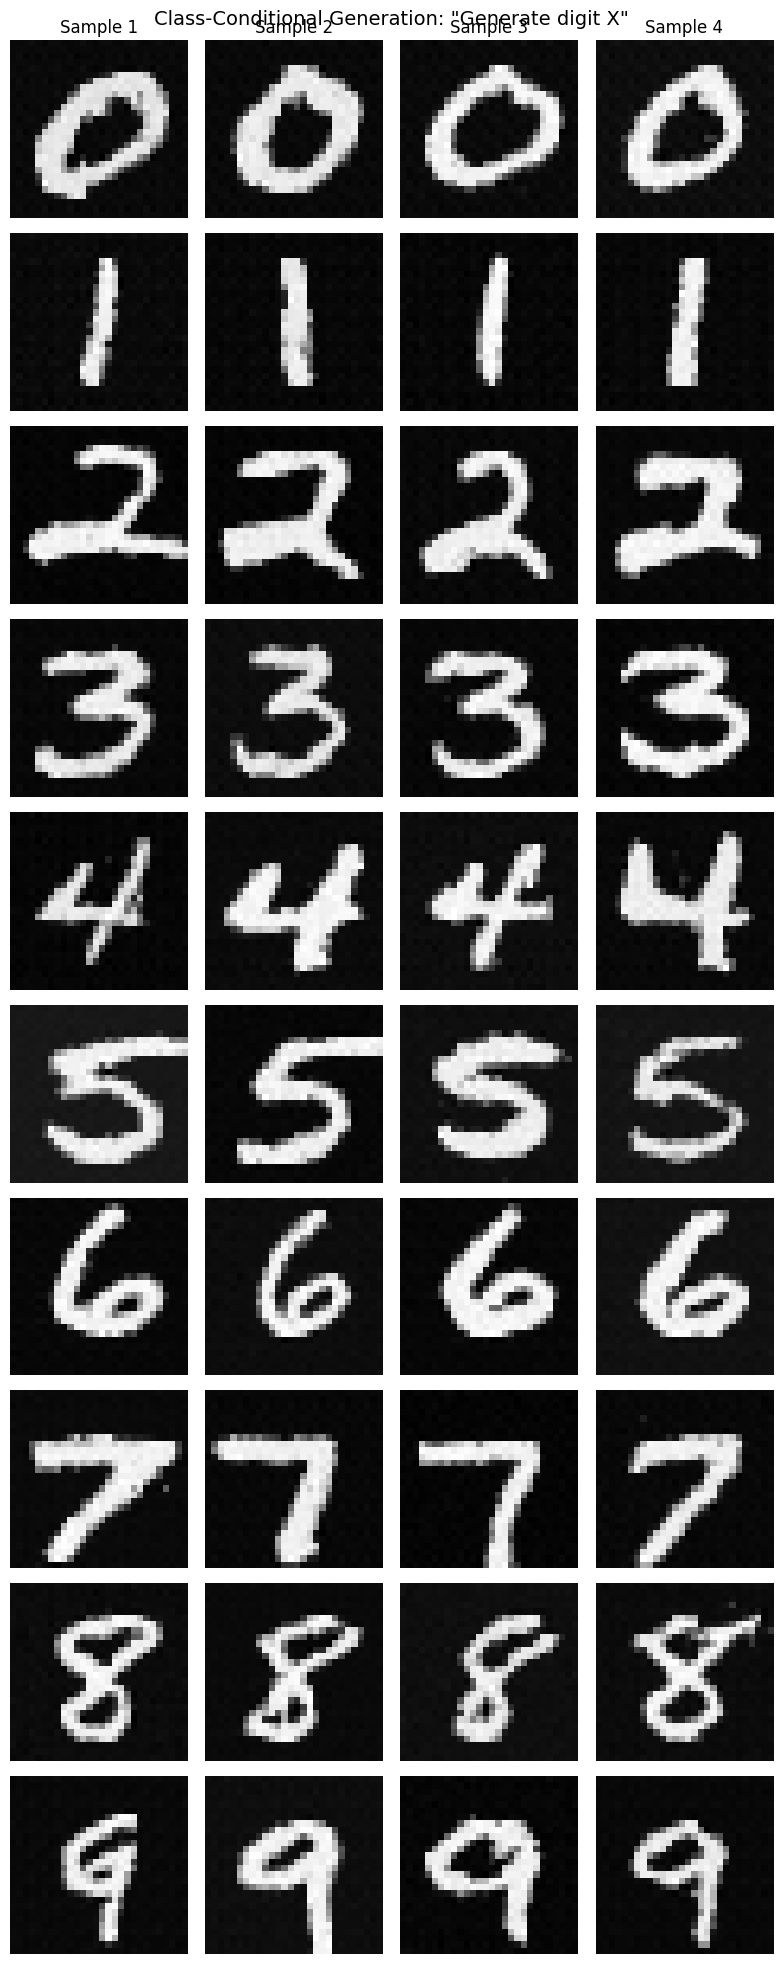

In [10]:
from from_noise_to_images.sampling import sample_conditional, sample_each_class

def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    images = (images + 1) / 2
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

# Generate samples for each class
model.eval()

print("Generating 4 samples for each digit (0-9) with CFG scale=4.0...")

samples = sample_each_class(
    model=model,
    num_per_class=4,
    image_shape=(1, 28, 28),
    num_steps=50,
    cfg_scale=4.0,
    device=device,
)

# Reshape for display: (40, 1, 28, 28) → (10, 4, 1, 28, 28)
samples_grid = samples.view(10, 4, 1, 28, 28)

# Create a nice display
fig, axes = plt.subplots(10, 4, figsize=(8, 20))

for digit in range(10):
    for i in range(4):
        img = (samples_grid[digit, i, 0] + 1) / 2
        axes[digit, i].imshow(img.cpu().numpy(), cmap='gray')
        axes[digit, i].axis('off')
        if i == 0:
            axes[digit, i].set_ylabel(f'{digit}', rotation=0, fontsize=14, labelpad=20)
        if digit == 0:
            axes[digit, i].set_title(f'Sample {i+1}')

plt.suptitle('Class-Conditional Generation: "Generate digit X"', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: Effect of Guidance Scale

The guidance scale $w$ controls the **trade-off between quality and diversity**:

### Mathematical Interpretation

$$v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})$$

- **Low $w$**: Samples closer to learned distribution → more diversity
- **High $w$**: Samples pushed toward class-specific regions → less diversity, higher fidelity

Let's visualize this trade-off:

Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

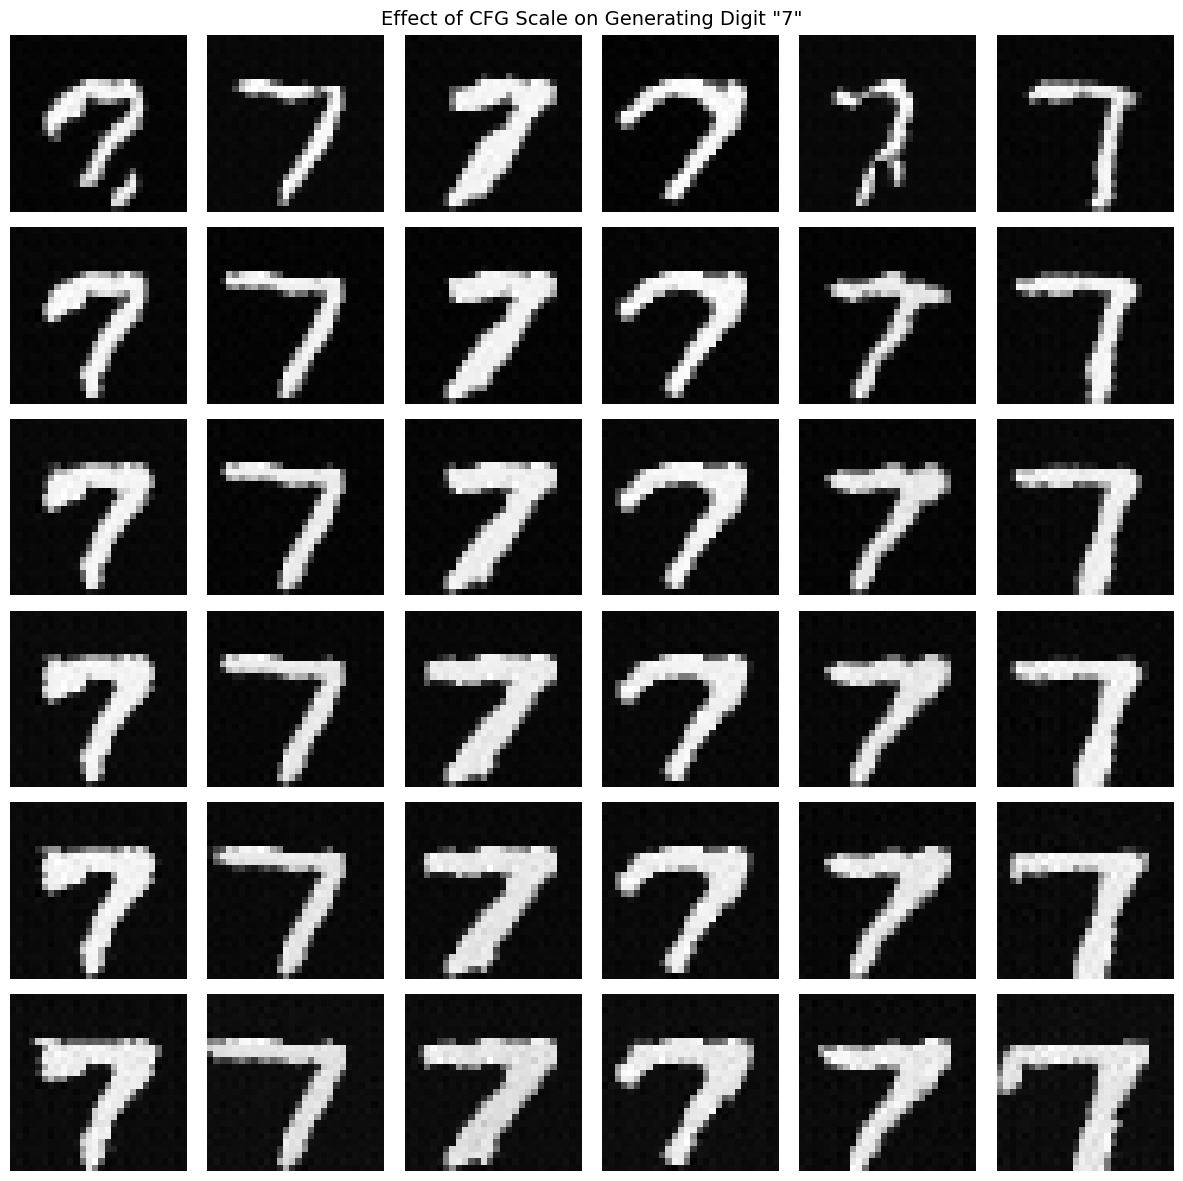


CFG Scale Analysis:
  • w=1.0: No guidance (pure conditional)
  • w=2-3: Light guidance, maintains diversity
  • w=4-5: Strong guidance, clear digit identity
  • w=7+: Very strong, may oversaturate


In [11]:
def compare_cfg_scales(model, target_digit=7, scales=[1.0, 2.0, 3.0, 4.0, 5.0, 7.0]):
    """
    Compare generation quality across different CFG scales.
    """
    num_samples = 6
    
    fig, axes = plt.subplots(len(scales), num_samples, figsize=(12, 2*len(scales)))
    
    for row, scale in enumerate(scales):
        # Use same seed for fair comparison
        torch.manual_seed(42)
        
        labels = torch.full((num_samples,), target_digit, dtype=torch.long)
        samples = sample_conditional(
            model=model,
            class_labels=labels,
            image_shape=(1, 28, 28),
            num_steps=50,
            cfg_scale=scale,
            device=device,
        )
        
        for col in range(num_samples):
            img = (samples[col, 0] + 1) / 2
            axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_ylabel(f'w={scale}', fontsize=11)
    
    plt.suptitle(f'Effect of CFG Scale on Generating Digit "{target_digit}"', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nCFG Scale Analysis:")
    print("  • w=1.0: No guidance (pure conditional)")
    print("  • w=2-3: Light guidance, maintains diversity")
    print("  • w=4-5: Strong guidance, clear digit identity")
    print("  • w=7+: Very strong, may oversaturate")

compare_cfg_scales(model, target_digit=7)

Generating 8 samples for each digit with CFG scale=4.0...



Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

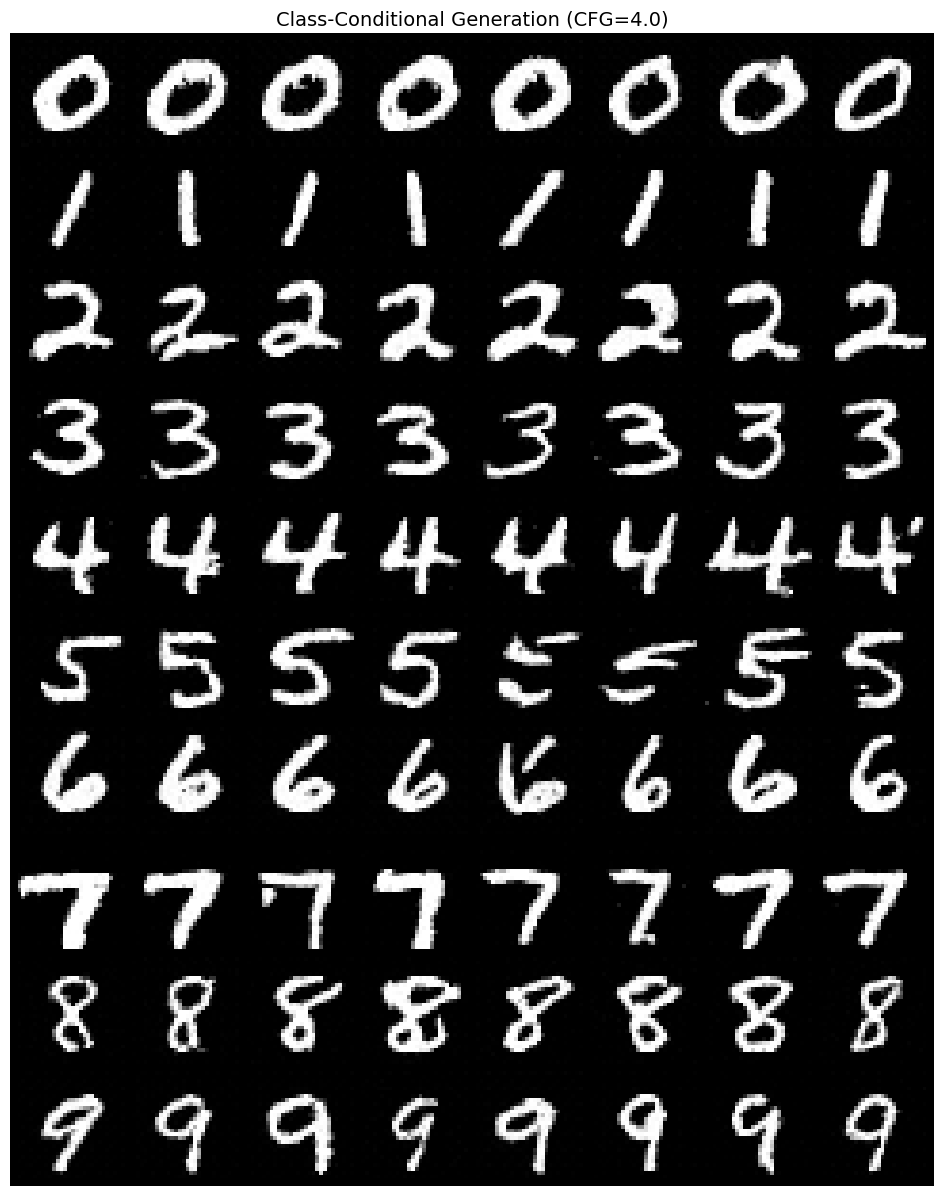

Each row is a different digit class (0-9)
Each column is a different sample from that class


In [12]:
# Compare generation for all digits at optimal CFG scale
print("Generating 8 samples for each digit with CFG scale=4.0...\n")

samples_all = sample_each_class(
    model=model,
    num_per_class=8,
    image_shape=(1, 28, 28),
    num_steps=50,
    cfg_scale=4.0,
    device=device,
)

# Show as 10 rows (one per digit), 8 columns (samples)
show_images(samples_all, nrow=8, title='Class-Conditional Generation (CFG=4.0)')

print("Each row is a different digit class (0-9)")
print("Each column is a different sample from that class")

## Step 9: Comparing Sampling Modes

Let's directly compare three sampling modes:

| Mode | Class Input | CFG Scale | What We're Sampling |
|------|-------------|-----------|--------------------|
| Unconditional | $\emptyset$ | N/A | $p(x)$ |
| Conditional (no CFG) | $y$ | $w=1$ | $p(x \mid y)$ |
| Conditional + CFG | $y$ | $w>1$ | "Sharpened" $p(x \mid y)$ |

Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03686863..1.1192801].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04630667..1.1642755].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.053089023..1.1483203].


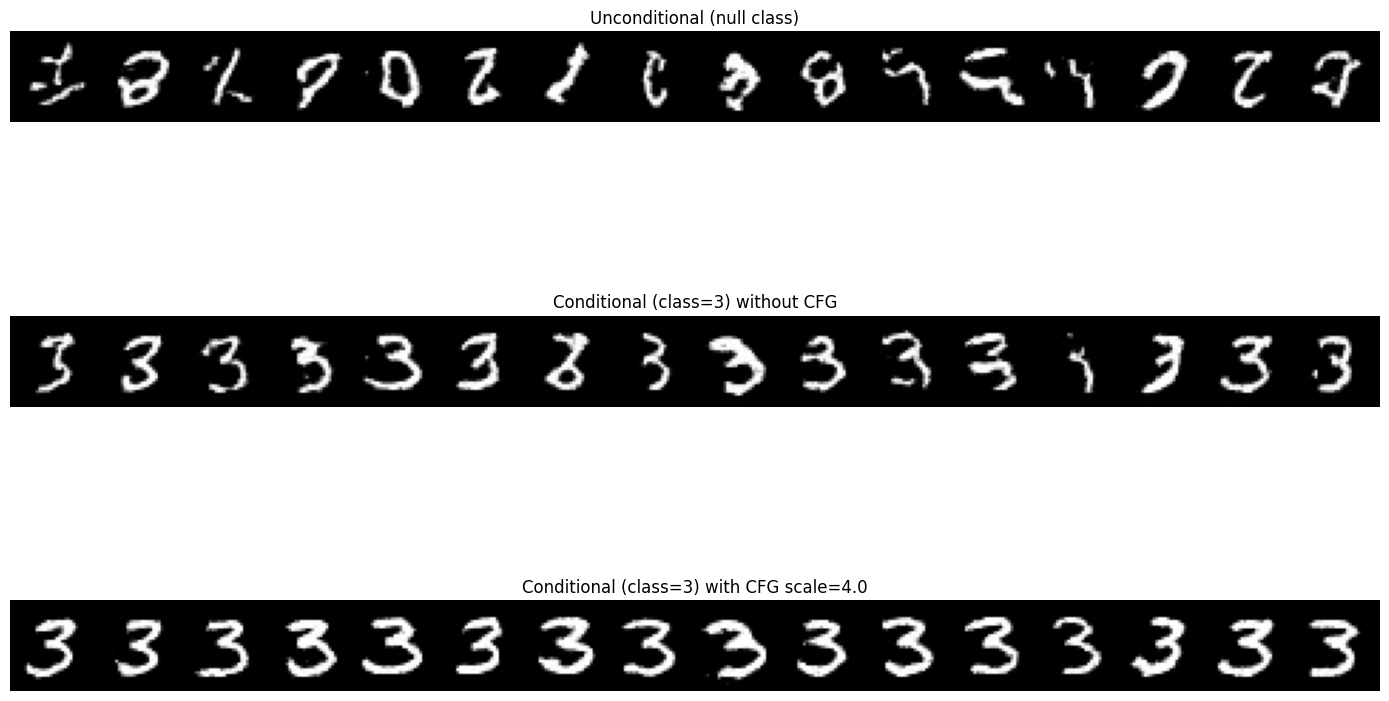


Comparison for generating '3':
  • Unconditional: Random digits (no control)
  • Conditional (no CFG): Tends toward 3 but may be weak
  • Conditional (CFG=4): Strong 3 identity


In [13]:
from from_noise_to_images.sampling import sample

torch.manual_seed(123)

target_class = 3  # Generate threes
num_samples = 16

# 1. Unconditional (no class)
null_labels = torch.full((num_samples,), 10, dtype=torch.long, device=device)  # 10 = null
uncond_samples = sample_conditional(
    model=model,
    class_labels=null_labels,
    image_shape=(1, 28, 28),
    cfg_scale=1.0,
    device=device,
)

# 2. Conditional without CFG
torch.manual_seed(123)
cond_nocfg_samples = sample_conditional(
    model=model,
    class_labels=[target_class] * num_samples,
    image_shape=(1, 28, 28),
    cfg_scale=1.0,
    device=device,
)

# 3. Conditional with CFG
torch.manual_seed(123)
cond_cfg_samples = sample_conditional(
    model=model,
    class_labels=[target_class] * num_samples,
    image_shape=(1, 28, 28),
    cfg_scale=4.0,
    device=device,
)

# Display comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for ax, samples, title in [
    (axes[0], uncond_samples, 'Unconditional (null class)'),
    (axes[1], cond_nocfg_samples, f'Conditional (class={target_class}) without CFG'),
    (axes[2], cond_cfg_samples, f'Conditional (class={target_class}) with CFG scale=4.0'),
]:
    grid = torchvision.utils.make_grid((samples + 1) / 2, nrow=16, padding=2)
    ax.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nComparison for generating '{target_class}':")
print("  • Unconditional: Random digits (no control)")
print(f"  • Conditional (no CFG): Tends toward {target_class} but may be weak")
print(f"  • Conditional (CFG=4): Strong {target_class} identity")

## Step 10: Analyzing Learned Embeddings

After training, the class embeddings should exhibit learned structure:

- **Semantic clustering**: Similar digits (3 and 8, 4 and 9) might be nearby
- **Null separation**: The null embedding should be distinct
- **Discriminability**: Different classes should be distinguishable

This structure emerges purely from the training objective - no explicit clustering loss.

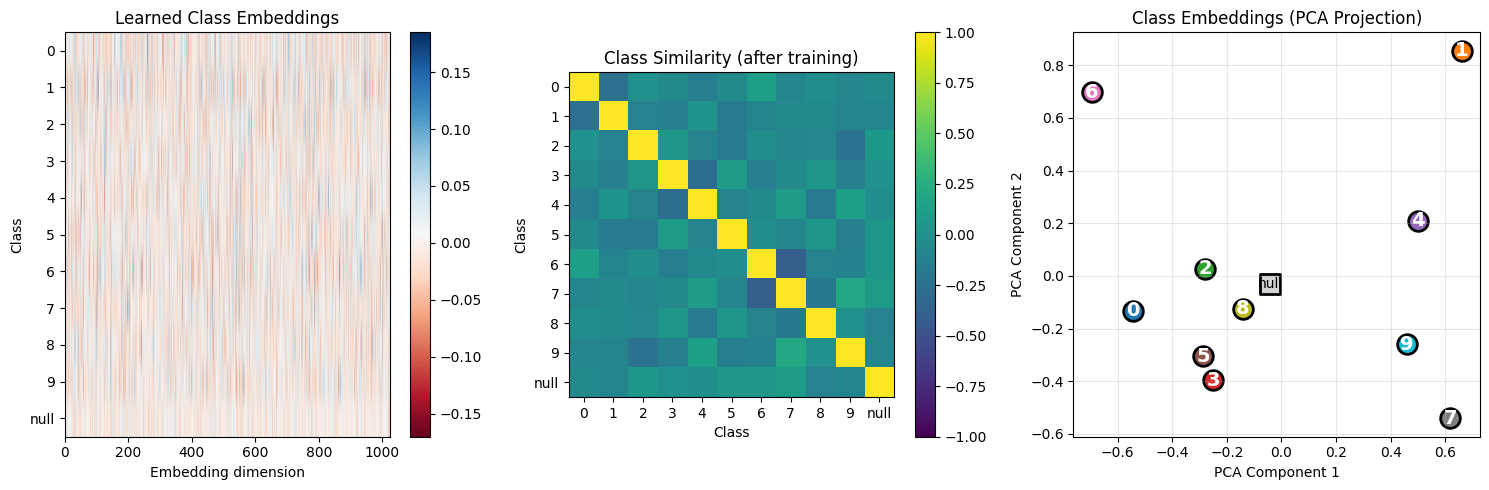


Learned Embedding Analysis:
  • Similarity matrix shows which digits the model considers 'similar'
  • PCA projection shows embedding space structure
  • Null class (gray square) should be somewhat central/neutral


In [14]:
# Extract learned class embeddings
with torch.no_grad():
    learned_embeddings = model.class_embed.embed.weight.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Embedding matrix
im = axes[0].imshow(learned_embeddings, aspect='auto', cmap='RdBu')
axes[0].set_xlabel('Embedding dimension')
axes[0].set_ylabel('Class')
axes[0].set_yticks(range(11))
axes[0].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[0].set_title('Learned Class Embeddings')
plt.colorbar(im, ax=axes[0])

# 2. Similarity matrix
similarity = np.corrcoef(learned_embeddings)
im = axes[1].imshow(similarity, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Class')
axes[1].set_xticks(range(11))
axes[1].set_xticklabels([str(i) for i in range(10)] + ['null'])
axes[1].set_yticks(range(11))
axes[1].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[1].set_title('Class Similarity (after training)')
plt.colorbar(im, ax=axes[1])

# 3. 2D PCA projection
def simple_pca(X, n_components=2):
    """Simple PCA using numpy SVD."""
    X_centered = X - X.mean(axis=0)
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    return X_centered @ Vt.T[:, :n_components]

embeddings_2d = simple_pca(learned_embeddings, n_components=2)

for i in range(10):
    axes[2].scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], s=200, 
                   c=[plt.cm.tab10(i)], edgecolors='black', linewidths=2)
    axes[2].annotate(str(i), (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=14, ha='center', va='center', color='white', fontweight='bold')

# Plot null class differently
axes[2].scatter(embeddings_2d[10, 0], embeddings_2d[10, 1], s=200,
               c='lightgray', edgecolors='black', linewidths=2, marker='s')
axes[2].annotate('null', (embeddings_2d[10, 0], embeddings_2d[10, 1]),
                fontsize=10, ha='center', va='center', color='black')

axes[2].set_xlabel('PCA Component 1')
axes[2].set_ylabel('PCA Component 2')
axes[2].set_title('Class Embeddings (PCA Projection)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLearned Embedding Analysis:")
print("  • Similarity matrix shows which digits the model considers 'similar'")
print("  • PCA projection shows embedding space structure")
print("  • Null class (gray square) should be somewhat central/neutral")

In [15]:
# Save the trained model
trainer.save_checkpoint("phase3_conditional_dit.pt")
print("Model saved to phase3_conditional_dit.pt")

Model saved to phase3_conditional_dit.pt


## Summary: The CFG Recipe

We extended the DiT with **class conditioning** and **Classifier-Free Guidance**.

### Key Equations

| Concept | Equation |
|---------|----------|
| Class embedding | $e(y) = W_e[y] \in \mathbb{R}^D$ |
| Combined conditioning | $c = \text{TimeEmbed}(t) + e(y)$ |
| Label dropout | $y_{\text{train}} = y$ w.p. 0.9, else $\emptyset$ |
| Training loss | $\mathcal{L} = \mathbb{E}[\|v_\theta(x_t, t, y_{\text{train}}) - v\|^2]$ |
| **CFG formula** | $\boxed{v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})}$ |

### CFG Derivation Summary

From Bayes' rule:
$$\nabla_x \log p(x \mid y) = \nabla_x \log p(x) + \nabla_x \log p(y \mid x)$$

The "classifier gradient" $\nabla_x \log p(y \mid x)$ is implicitly:
$$\nabla_x \log p(y \mid x) \propto v_{\text{cond}} - v_{\text{uncond}}$$

CFG amplifies this by factor $w$.

### Recommended Hyperparameters

| Parameter | Typical Value | Effect |
|-----------|--------------|--------|
| Label dropout $p_{\text{drop}}$ | 0.1 | Enables CFG |
| CFG scale $w$ | 3-5 | Quality/diversity trade-off |
| Embedding dim $D$ | 1024 | Same as conditioning dimension |

## What's Next

In the next notebook, we move from **class labels** to **text prompts**:

| This Notebook | Next Notebook |
|---------------|---------------|
| $y \in \{0, \ldots, 9\}$ | $y = \text{"a photo of a cat"}$ |
| Embedding table $W_e$ | CLIP text encoder |
| Addition to timestep | Cross-attention |

The mathematical principles remain the same - we're just using richer conditioning!